<a href="https://colab.research.google.com/github/gravity102424/ESAA/blob/main/ESAA_YB_week10_2_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

**규제 선형 모델의 개요**

좋은 머신러닝 회귀 모델의 특징은 무엇일까.
회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 한다.

이전까지 선형 모델의 비용 함수는 RSS를 최소화하는, 즉 실제 값과 예측값의 차이를 최소화하는 것만 고려했는데 그러다 보니 학습 데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커졌다. 이럴 경우 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉽다. 이를 반영해 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이뤄야 한다.

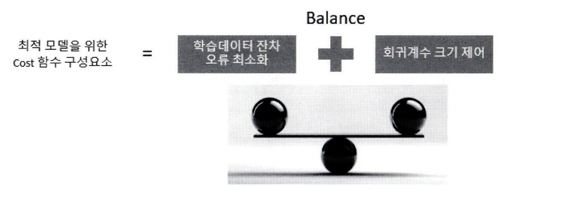


이렇게 회귀 계수의 크기를 제어해 과적합을 개선하려면 비용(Cost) 함수의 목표가 다음과 같이 RSS(W) + alpha* $\left\| W\right\| _{2}^{2}$를 최소화하는 것으로 변경될 수 있다.

비용 함수 목표 = Min(RSS(W) + alpha* $\left\| W\right\| _{2}^{2}$)

여기서 alpha는 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터이다. 비용 함수의 목표가 (RSS(W) + alpha* $\left\| W\right\| _{2}^{2}$)를 최소화하는 W 벡터를 찾는 것일 때 alpha가 어떤 역할을 하는지 살펴보자.

alpha가 0(또는 매우 작은 값)이라면 비용 함수 식은 기존과 동일한 Min(RSS(W) + 0)이 될 것이다. 반면에 alpha가 무한대(또는 매우 큰 값)라면 비용 함수 식은 RSS(W)에 비해  alpha* $\left\| W\right\| _{2}^{2}$ 값이 너무 커지게 되므로 W 값을 0(또는 매우 작게)으로 만들어야 Cost가 최소화되는 비용 함수 목표를 달성할 수 있다. 즉, alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있으며 alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있다.

* alpha = 0 인 경우는 W가 커도 alpha*$\left\| W\right\| _{2}^{2}$가 0이 되어 비용 함수는 Min(RSS(W))

* alpha = 무한대인 경우 alpha*$\left\| W\right\| _{2}^{2}$도 무한대가 되므로 비용 함수는 W를 0에 가깝게 최소화해야 함.


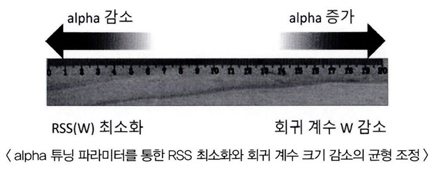

즉, alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있다. 이처럼 비용 함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regularization)라고 부른다. 규제는 크게 L2 방식과 L1 방식으로 구분된다. L2 규제는 위에서 설명한 바와 같이 alpha*$\left\| W\right\| _{2}^{2}$와 같이 W의 제곱에 대해 패널티를 부여하는 방식을 말한다. L2 규제를 적용한 회귀를 릿지(Ridge) 회귀라고 한다. 라쏘(Lasso) 회귀는 L1 규제를 적용한 회귀이다. L1 규제는 alpha*$\left\| W\right\| _{1}$와 같이 W의 절댓값에 대해 페널티를 부여한다. L1 규제를 적용하면 영향력이 크지 않은 회귀 계수 값을 0으로 변환한다.

**릿지 회귀**

사이킷런은 Ridge 클래스를 통해 릿지 회귀를 구현한다. Ridge 클래스의 주요 생성 파라미터는 alpha이며, 이는 릿지 회귀의 alpha L2 규제 계수에 해당한다. 앞 예제의 보스턴 주택 가격을 Ridge 클래스를 이용해 다시 예측하고, 예측 성능을 cross_val_score()로 평가해 보자. 앞의 LinearRegression 예제에서 사용한 피처 데이터 세트인 X_data와 Target 데이터 세트인 y_target을 그대로 이용한다.


In [2]:
# Dataset 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen

# 데이터 가져오기
raw_df = urlopen('http://lib.stat.cmu.edu/datasets/boston')
data = raw_df.read().decode('utf-8').split('\n')[22:]  # 앞부분은 설명이므로 제외

# 숫자 데이터만 추출
data = [d.strip().split() for d in data if d.strip() != '']
data = [item for sublist in data for item in sublist]  # 1차원 리스트로 flatten
data = np.array(data, dtype='float')

# 실제 feature는 13개인데 2줄로 나뉘어 있어서 이를 합쳐줌
X = np.array([data[i:i+13] for i in range(0, len(data), 14)])
y = np.array([data[i] for i in range(13, len(data), 14)])

# DataFrame 생성
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
           'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
bostonDF = pd.DataFrame(X, columns=columns)
bostonDF['PRICE'] = y

# 확인
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
from sklearn.model_selection import train_test_split

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                    random_state=156)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores,3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores,3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


릿지의 5개 폴드 세트의 평균 RMSE가 5.518이다. 앞 예제의 규제가 없는 LinearRegression의 RMSE 평균인 5.829보다 더 뛰어난 예측 성능을 보여준다.

이번에는 릿지의 alpha 값을 0, 0.1, 1, 10, 100으로 변화시키면서 RMSE와 회귀 계수를 시각화하고 DataFrame에 저장하는 예제이다. alpha값을 변화하면서 RMSE 값과 각 피처의 회귀 계수를 시각화하고 DataFrame에 저장하는 예제이다. 예제의 결과에서 보겠지만, 릿지 회귀는 alpha 값이 커질수록 회귀 계수 값을 작게 만든다. 먼저 alpha 값의 변화에 따른 5 폴드의 RMSE 평균값을 반환하는 코드부터 작성하겠다.

In [5]:
# 릿지에 사용될 alpha 파라미터 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
  ridge = Ridge(alpha=alpha)

  # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330


alpha가 100일 때 평균 RMSE가 5.330으로 가장 좋다. 이번에는 alpha 값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화해 보겠다. 회귀 계수를 Ridge 객체의 coef_ 속성에서 추출한 뒤에 Series 객체로 만들어서 시본 가로 막대 차트로 표시하고, DataFrame에 alpha 값별 회귀 계수로 저장한다.

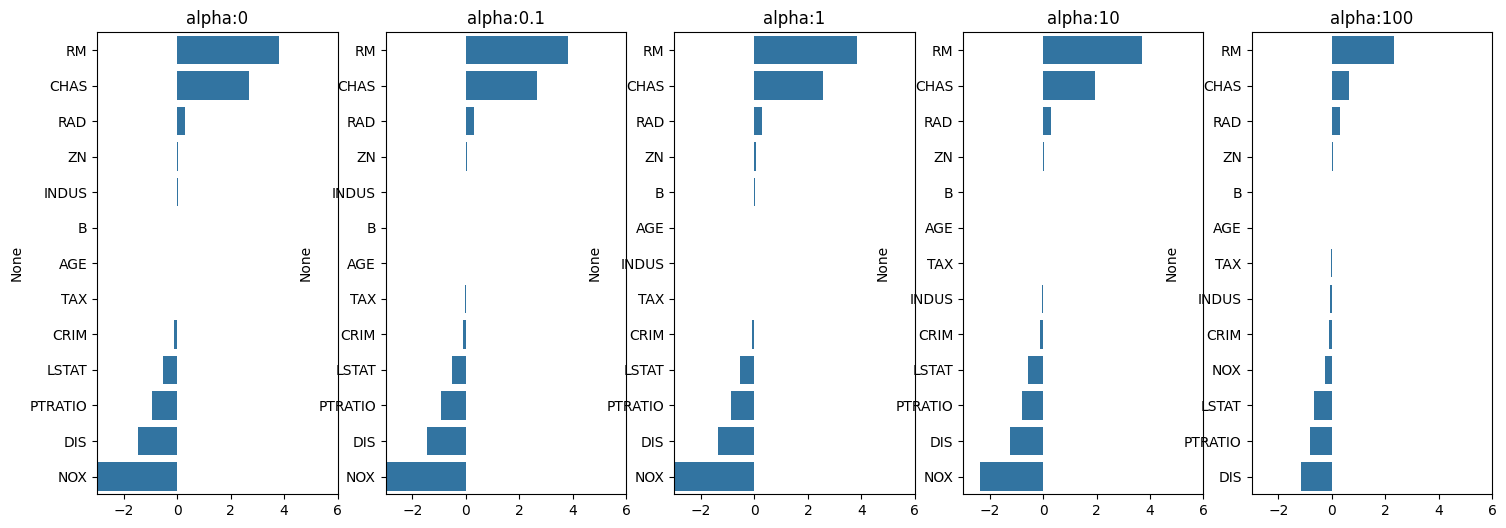

In [6]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_data, y_target)
  # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname = 'alpha:' + str(alpha)
  coeff_df[colname] = coeff
  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐을 알 수 있다. 특히 NOX 피처의 경우 alpha 값을 계속 증가시킴에 따라 회귀 계수가 크게 작아지고 있다. DataFrame에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수 값을 구해 보겠다.

In [7]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음을 알 수 있다. 하지만 릿지 회귀의 경우에는 회귀 계수를 0으로 만들지는 않습니다.

**라쏘 회귀**
W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘(Lasso) 회귀이다. 즉 L1 규제는 alpha*$||W||_{1}$를 의미하며, 라쏘 회귀 비용함수의 목표는 RSS(W)+alpha*$||W||_{1}$식을 최소화하는 W를 찾는 것이다. L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거한다. 이러한 측면에서 L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있다.

사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현했다. Lasso 클래스의 주요 생성 파라미터는 alpha이며, 이는 라쏘 회귀의 alpha L1 규제 계수에 해당한다. 이 Lasso 클래스를 이용해 바로 이전의 릿지 회귀 예제 코드와 유사하게 라쏘의 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력해 보겠다. 뒤에서 설명하는 엘라스틱넷도 동일하게 alpah값을 변화시키면서 결과를 출력할 것이므로 이의 수행을 위한 별도의 함수를 만들겠다. get_linear_reg_eval()는 인자로 회귀 모델의 이름, alpha값들의 리스트, 피처 데이터 세트와 타깃 데이터 세트를 입력받아서 alpha값에 따른 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환한다. 다음 예제 코드는 get_linear_reg_eval() 함수를 구현한 것이며, 앞의 릿지 예제 코드와 크게 다르지 않다.

In [8]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose: print('######', model_name, '######')
  for param in params:
    if model_name == 'Ridge': model = Ridge(alpha=param)
    elif model_name == 'Lasso': model = Lasso(alpha=param)
    elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    # cross_val_scroe는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    model.fit(X_data_n, y_target_n)
    if return_coeff:
      # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:' + str(param)
      coeff_df[colname] = coeff

  return coeff_df
# end of get_linear_regre_eval

함수를 생성했으면 이를 이용해 alpha값의 변화에 따른 RMSE와 그때의 회귀계수들을 출력해 보겠다. alpha값은 [0.07, 0.1, 0.5, 1,3]로 입력하겠다. get_linear_reg_eval()에 모델명을 'Lasso'로 입력하면 라쏘 모델 기반으로 수행한다.

In [9]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


alpha가 0.07일 때 5.612로 가장 좋은 평균 RMSE를 보여준다. 앞의 릿지 평균 5.518보다는 약간 떨어지는 수치지만, LinearRegression 평균인 5.829보다는 향상됐다. 다음은 alpha 값에 따른 피처별 회귀 계수이다.

In [10]:
# 반환된 coeff_lasso_df를 첫 번쨰 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수를 아예 0으로 바뀌고 있다. NOX 속성은 alpha가 0.07일 때부터 회귀 계수가 0이며, alpha를 증가시키면서 INDUS, CHAS와 같은 속성의 회귀 계수가 0으로 바뀐다. 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있다.

엘라스틱넷 회귀
엘라스틱넷(Elastic Net) 회귀는 L2 규제와 L1 규제를 결합한 회귀이다. 따라서 엘라스틱넷 회귀 비용함수의 목표는 RSS(W)+alpha2*$||W||^{2}_{2}$+alpha1*$||W||_{1}$식을 최소화하는 W를 찾는 것이다. 엘라스틱넷은 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강하다. 특히 이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급격히 변동할 수도 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것이다. 반대로 엘라스틱넷 회귀의 단점은 L1과 L2 규제가 결합된 규제로 인해 수행시간이 상대적으로 오래 걸린다는 것이다.

사이킷런은 ElasticNet 클래스를 통해서 엘라스틱넷 회귀를 구현한다. ElasticNet 클래스의 주요 생성 파라미터는 alpha와 l1_ratio이다. ElasticNet 클래스의 alpha는 Ridge와 Lasso 클래스의 alpha값과는 다르다. 엘라스틱넷의 규제는 a*L1+b*L2로 정의될 수 있으며, 이때 a는 L1 규제의 alpha값, b는 L2 규제의 alpha값이다. 따라서 ElasticNet 클래스의 alpha 파라미터 값은 a+b이다. ElasticNet 클래스의 l1_ratio 파라미터 값은 a / (a+b)이다. l1_ratio가 0이면 a가 0이므로 L2 규제와 동일하다. l1_ratio가 1이면 b가 0이므로 L1 규제와 동일하다.

ElasticNet 클래스를 이용해 바로 이전의 릿지, 라쏘 회귀 예제 코드와 유사하게 엘라스틱넷 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력해 보겠다. 앞에서 생성한 get_linear_reg_eval() 함수를 이용하겠다. 먼저 해당 함수를 호출하기 전에 잠시 주지해야 할 점이 있다. 앞의 get_linear_reg_eval()를 생성한 예제를 잠시 돌아 보면 elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)으로 ElasticNet 객체를 생성할 때 l1_ratio를 0.7로 고정했다. 이는 단순히 alpha값의 변화만 살피기 위함으로 l1_ratio를 미리 고정했음을 밝혀둔다.

In [11]:
# 엘라스틱넷에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [12]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha 0.5일 때 RMSE가 5.467로 가장 좋은 예측 성능을 보이고 있다. alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있다.

지금까지 규제 선형 회귀의 가장 대표적인 기법인 릿지, 라쏘, 엘라스틱넷 회귀를 살펴봤다. 이들 중 어떤 것이 가장 좋은 지는 상황에 따라 다르다. 각각의 알고리즘에서 하이퍼 파라미터를 변경해 가면서 최적의 예측 성능을 찾아내야 한다. 하지만 선형 회귀의 경우 최적의 하이퍼 파라미터를 찾아내는 것 못지않게 먼저 데이터 분포도의 정규화와 인코딩 방법이 매우 중요하다.

**선형 회귀 모델을 위한 데이터 변환**

선형 회귀 모델과 같은 선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고, 이러한 최적의 선형함수를 찾아내 결괏값을 예측한다. 또한 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포(즉 평균을 중심으로 종 모양으로 데이터 값이 분포된 형태) 형태를 매우 선호한다. 특히 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡(Skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높다. 피처값 역시 결정값보다는 덜하지만 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있다. 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적이다. 하지만 이러한 스케일링/정규화 작업을 선행한다고 해서 무조건 예측 성능이 향상되는 것은 아니다. 일반적으로 중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 경우에 이러한 변환 작업을 수행한다.

일반적으로 피처 데이터 세트와 타깃 데이터 세트에 이러한 스케일링/정규화 작업을 수행하는 방법이 조금은 다르다. 사이킷런을 이용해 피처 데이터 세트에 적용하는 변환 작업은 다음과 같은 방법이 있을 수 있다.

1. StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고 최댓값이 1인 값으로 정규화를 수행한다.
2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법이다. 보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 이와 같은 방법을 적용한다.
3. 원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포된다. 이러한 변환을 로그 변환(Log Transformation)이라고 부른다. 로그 변환은 매우 유용한 변환이며, 실제로 선형 회귀에서는 앞에서 소개한 1. 2 번 방법보다 로그 변환이 훨씬 많이 사용되는 변환 방법이다. 왜냐하면 1번 방법의 경우 예측 성능 향상을 크게 기대하기 어려운 경우가 많으며 2번 방법의 경우 피처의 개수가 매우 많을 경우에는 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어나서 과적합의 이슈가 발생할 수 있기 때문이다.

타깃값의 경우는 일반적으로 로그 변환을 적용한다. 결정 값을 정규 분포나 다른 정규값으로 변환하면 변환된 값을 다시 원본 타깃값으로 원복하기 어려울 수 있다. 무엇보다도, 왜곡된 분포도 형태의 타깃값을 로그 변환하여 예측 성능 향상이 된 경우가 많은 사례에서 검증되었기 때문에 타깃값의 경우는 로그 변환을 적용한다.

보스턴 주택가격 피처 데이터 세트에 위에서 언급한 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그 변환을 차례로 적용한 후에 RMSE로 각 경우별 예측 성능을 측정해 보겠다. 이를 위해 get_scaled_data() 함수를 생성한다. 해당 함수는 method 인자로 변환 방법을 결정하며 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규호RMinMax), 로그 변환(Log) 중에 하나를 선택한다. p_degree는 다항식 특성을 추가할 때 다항식 차수가 입력된다. 다항식 차수는 2를 넘기지 않는다. 그리고 로그 변환인 경우 예제 코드에서 np.log()가 아니라 np.loglp()를 이용했다. 일반적으로 logO 함수를 적용하면 언더 플로우가 발생하기 쉬운데, 이를 예방하기 위해서 인자값에 1을 더하는 방식으로 구현한 것이 np.loglp()이다.

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

  return scaled_data

이제 Ridge 클래스의 alpha 값을 변화시키면서 피처 데이터 세트를 여러 가지 방법으로 변환한 데이터 세트를 입력받을 경우에 RMSE 값이 어떻게 변하는지 살펴보겠다. 앞에서 생성한 get_linear_reg_eval( ) 함수를 다시 이용하겠다. 피처 데이터의 변환 방법은 모두 5가지이다. 먼저 (None, None)은 아무런 변환을 하지 않은 원본 데이터, ('Standard', None)은 표준 정규 분포, ('Standard', 2)는 표준 정규 분포를 다시 2차 다항식 변환, ('MinMax', None)은 최솟값/최댓값 정규화, ('MinMax', 2)는 최솟값/최댓값 정규화를 다시 2차 다항식 변환, ('Log', None)은 로그 변환이다.

In [14]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1,1,10,100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다향식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard',None), ('Standard', 2),
               ('MinMax', None), ('MinMax',2), ('Log', None)]
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                  input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.770

결과를 보면 표준 정규 분포와 최솟값/최댓값 정규화로 피처 데이터 세트를 변경해도 성능상의 개선은 없다. 표준 정규 분포로 일차 변환 후 2차 다항식 변환을 했을 때 alpha=100에서 4.634로 성능이 개선됐으며 최솟값/최댓값 정규화로 일차 변환 후 2차 다항식 변한을 했을 때 alpha=l에서 4.323으로 성능이 개선됐다. 하지만 다항식 변환은 앞에서 언급한 단점으로 인해 피처의 개수가 많을 경우 적용하기 힘들며, 또한 데이터 건수가 많아지면 계산에 많은 시간이 소모되어 적용에 한계가 있다. 반면에 로그 변환을 보면 alpha가 0.1, 1, 10인 경우에 모두 좋은 성능 향상이 있음을 알 수 있다. 일반적으로 선형 회귀를 적용하려는 데이터 세트에 데이터 값의 분포가 심하게 왜곡되어 있을 경우에 이처럼 로그 변환을 적용하는 것이 좋은 결과를 기대할 수 있다.

# 07. 로지스틱 회귀
로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘이다. 즉, 로지스틱 회귀는 분류에 사용된다. 로지스틱 회귀 역시 선형 회귀 계열이다. 회귀가 선형인가 비선형인가는독립변수가 아닌 가중치(weight) 변수가 선형인지 아닌지를 따른다. 로지스틱 회귀가 선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드(Sigmoid) 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것이다.

많은 자연, 사회 현상에서 특정 변수의 확률 값은 선형이 아니라 위의 시그모이드 함수와 같이 S자 커브 형태를 가진다. 시그모이드 함수의 정의는 y = 1/(1+exp(-x))이다. 위의 그림과 식에서 알 수 있듯이 시그모이드 함수는 x 값이 +, -로 아무리 커지거나 작아져도 y 값은 항상 0과 1 사이 값을 반환한다. x 값이 커지면 1에 근사하며 x 값이 작아지면 0에 근사한다. 그리고 x가 0일 때는 0.5이다.

지금까지는 부동산 가격과 같은 연속형 값을 구하는 데 회귀를 사용했다. 이번에는 회귀 문제를 약간 비틀어서 분류 문제에 적용해 보겠다. 가령 종양의 크기에 따라 악성 종양인지(Yes = 1) 그렇지 않은지(No=0)를 회귀를 이용해 1과 0의 값으로 예측하는 것이다. 종양 크기에 따라 악성이 될 확률이 높다고 한다면 다음 그림의 왼쪽과 같이 종양 크기를 X축, 악성 종양 여부를 Y 축에 표시할 때 데이터 분포가 그림과 같이 될 수 있으며, 이에 회귀를 적용하면 데이터가 모여 있는 곳으로 선형 회귀 선을 그릴 수 있다. 하지만 이 회귀 라인은 0과 1을 제대로 분류하지 못하고 있다(선형 회귀가 분류를 못하는 건 아니지만 정확도가 떨어진다). 하지만 오른쪽 그림과 같이 S자 커브 형태의 시그모이드 함수를 이용하면 좀 더 정확하게 0과 1에 대해 분류를 할 수 있음을 알 수 있다. 로지스틱 회귀는 이처럼 선형 회귀 방식을 기반으로 하되 시그모이드 함수를 이용해 분류를 수행하는 회귀이다.

사이킷런은 로지스틱 회귀를 위해서 LogisticRegression 클래스를 제공한다. LogisticRegression 클래스의 회귀 계수 최적화는 본 장의 초반부에 소개해 드린 경사 하강법 외에 다양한 최적화 방안을 선택할 수 있다. LogisticRegression 클래스에서 solver 파라미터의 'Ibfgs', 'liblinea', 'newton-cg', 'sag', 'saga' 값을 적용해서 최적화를 선택할 수 있다.

* Ibfgs: 사이컷런 버전 0.22부터 solver의 기본 설정값이다. 메모리 공간을 절약할 수 있고, CPU 코어 수가 많다면 최적화를 병렬로 수행할 수 있다.
* liblinear: 사이킷런 버전 0.21까지 solver의 기본 설정값이다. 다차원이고 작은 데이터 세트에서 효과적으로 동작하지만 국소 최적화(Local Minimum)에 이슈가 있고, 병렬로 최적화할 수 없다.
* newton-cg: 좀 더 정교한 최적화를 가능하게 하지만, 대용량의 데이터에서 속도가 많이 느려진다.
* sag: Stochastic Average Gradient로서 경사 하강법 기반의 최적화를 적용한다. 대용량의 데이터에서 빠르게 최적화한다.
* saga: sag와 유사한 최적화 방식이며 L1 정규화를 가능하게 해준다.

다양한 solver 값들이 있지만 이들간의 성능 차이는 미비하며 일반적으로 Ibfgs 또는 liblinear를 선택하는 것이 대부분이다. 작은 데이터 세트에서 liblinear가 좀 더 효과적으로 동작한다는 사이킷런 문서의 설명이 있지만, 이를 일반화하기는 어렵다. 다만 이 책 전반에 걸친 예제의 경우 사이킷런의 기본 solver 값인 Ibfgs보다는 liblinear가 좀 더 빠르게 수행되며 수행 성능이 약간 나은 결과를 나타내고 있다.

이제 사이킷런의 LogisticRegression 클래스를 이용하여 위스콘신 유방암 데이터 세트 기반에서 로지스틱 회귀로 암 여부를 판단해 보겠다. 먼저 사이킷런의 load_breast_cancer()를 호출해 전체 데이터 세트를 생성한다.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

선형 회귀 계열의 로지스틱 회귀는 데이터의 정규 분포도에 따라 예측 성능 영향을 받을 수 있으므로 데이터에 먼저 정규 분포 형태의 표준 스케일링을 적용한 뒤에 train_test_split()을 이용해 데이터 세트를 분리하겠다.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평군이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

이제 로지스틱 회귀를 이용해 학습 및 예측을 수행하고, 정확도와 ROC-ACC 값을 구해 보겠다. 먼저 solver 값을 'lbfgs'로 설정하고 성능을 확인해 보겠다. 기본 solver 값은 'lbfgs'이므로 solver인자값을 LogisticRegression() 생성자로 입력하지 않으면 자동으로 solver='lbfgs'로 할당된다.

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용해 학습 및 예측 수행
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

# accuracy와 roc_auc 측정
print('accuracy:{0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy:0.977, roc_auc:0.995


solver가 ldfgs일 경우 정확도가 0.977, ROC-AUC가 0.995로 도출되었다.

이번에는 서로 다른 solver 값으로 LogisticRegrssion을 학습하고 성능 평가를 해보겠다. 특정 solver는 최적화에 상대적으로 많은 반복횟수가 필요할 수 있다. 따라서 max_iter 값을 600으로 설정해보겠다. max_iter는 solver로 지정된 최적화 알고리즘이 최적 수렴할 수 있는 최대 반복 회수이다. max_iter=600이면 최적화 알고리즘이 수렴할 때까지 최대 600번까지 반복하여 회귀 계수를 최적화한다.

In [19]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
  lr_clf = LogisticRegression(solver=solver, max_iter=600)
  lr_clf.fit(X_train, y_train)
  lr_preds = lr_clf.predict(X_test)
  lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

  # accuracy와 roc_auc 측정
  print('solver:{0}, accuracy:{1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy:0.977, roc_auc:0.995
solver:liblinear, accuracy:0.982, roc_auc:0.995
solver:newton-cg, accuracy:0.977, roc_auc:0.995
solver:sag, accuracy:0.982, roc_auc:0.995
solver:saga, accuracy:0.982, roc_auc:0.995


liblinear와 sag, saga일 경우에 정확도가 0.982, ROC—AUC가 0.995로 Ibfgs나 newton-cg 대비하여 상대적인 성능 수치가 약간 높지만, 데이터 세트가 워낙 작기 때문에 개별 solver별 성능 결과의 차이는 크게 의미 있는 결과는 아니다. 다만 여러 데이터 세트에 적용을 해보아도 solver별 차이는 크지 않다.

Solver와 max_iter 외에 사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터로 penalty와 C가 있다. penalty는 규제(Regularization)의 유형을 설정하며 'l2'로 설정 시 L2 규제를, ';1'으로 설정 시 L1 규제를 뜻한다. 기본은 'l2'이다. C는 규제 강도를 조절하는 alpha 값의 역수이다. 즉 C = 1/alpha이다. C 값이 작을수록 규제 강도가 크다.

LI, L2 규제의 경우 solver 설정에 따라 영향을 받는다. Liblinear, saga의 경우 LI, L2 규제가 모두 가능하지만 Ibfgs, newton-cg, sag의 경우는 L2 규제만 가능하다.

GridSearchCV를 이용해 위스콘신 데이터 세트에서 solver, penalty, C를 최적화해보겠다.

In [20]:
from sklearn.model_selection import GridSearchCV

params={'solver':['liblinear','lbfgs'],
        'penalty':['l2','l1'],
        'C':[0.01,0.1,1,5,10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

solver가 liblinear, Penalty가 L2 규제, C 값은 0.1 일 때, 평균 정확도가 0.979로 가장 좋은 성능을 나
타내었다. 그리고 FitFailedWarning 메시지가 함께 나오는데, 이는 solver가 Ibfgs일 때 L1 규제
를 지원하지 않음에도 GridSearchCV에서 L1 규제값을 입력했기 때문에 나오는 메시지이다.
로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어나다. 이 때문에 로지스틱 회귀를 이
진 분류의 기본 모델로 사용하는 경우가 많다. 또한 로지스틱 회귀는 희소한 데이터 세트 분류에도
뛰어난 성능을 보여서 텍스트 분류에서도 자주 사용된다.

# 08. 회귀 트리

지금까지 선형 회귀에 대해 알아봤다. 선형 회귀는 회귀 계수의 관계를 모두 선형으로 가정하는 방식이다. 일반적으로 선형 회귀는 회귀 계수를 선형으로 결합하는 회귀 함수를 구해, 여기에 독립변수를 입력해 결괏값을 예측하는 것이다. 비선형 회귀 역시 비선형 회귀 함수를 통해 결괏값을 예측한다. 다만 비선형 회귀는 회귀 계수의 결합이 비선형일 뿐이다. 앞의 경사 하강법에서도 말했듯이, 머신러닝 기반의 회귀는 회귀 계수를 기반으로 하는 최적 회귀 함수를 도출하는 것이 주요 목표이다.
이 절에서는 회귀 함수를 기반으로 하지 않고 결정 트리와 같이 트리를 기반으로 하는 회귀 방식을 소개하겠다.

트리 기반의 회귀는 회귀 트리를 이용하는 것이다. 즉, 회귀를 위한 트리를 생성하고 이를 기반으로
회귀 예측을 하는 것이다. 회귀 트리는 앞 4장의 분류에서 언급했던 분류 트리와 크게 다르지 않다. 다만 리프 노드에서 예측 결정 값을 만드는 과정에 차이가 있는데, 분류 트리가 특정 클래스 레이블
을 결정하는 것과는 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계
산한다.

매우 간단한 데이터 세트를 이용해 회귀 트리가 어떻게 동작하는지 살펴보겠습니다. 피처가 단 하나인 X 피처 데이터 세트와 결정값 Y가 2차원 평면상에 다음 그림과 같이 있다고 가정하겠다.


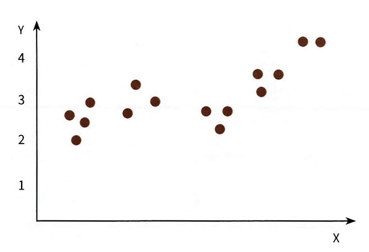

이 데이터 세트의 X 피처를 결정 트리 기반으로 분할하면 X값의 균일도를 반영한 지니 계수에 따라 다음 그림의 왼쪽과 같이 분할할 수 있다. 루트 노드를 Split 0 기준으로 분할하고 이렇게 분할된 규칙 노드에서 다시 Split 1과 Split 2 규칙 노드로 분할할 수 있다. 그리고 Split 2는 다시 재귀적으로 Split 3 규칙 노드로 다음 그림의 오른쪽과 같이 트리 규칙으로 변환될 수 있다.

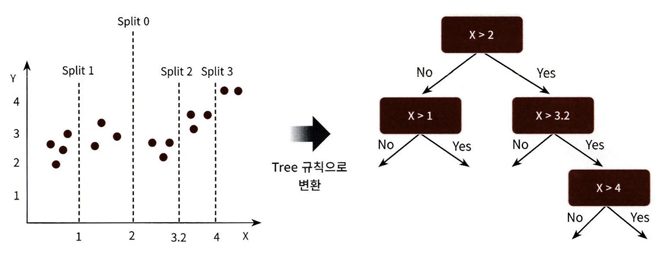

리프 노드 생성 기준에 부합하는 트리 분할이 완료됐다면 리프 노드에 소속된 데이터 값의 평균값을 구해서 최종적으로 리프 노드에 결정 값으로 할당한다.

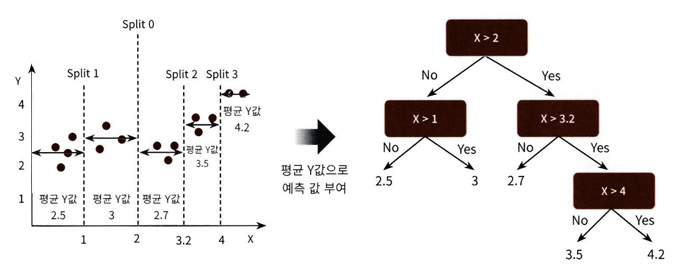

결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등의 앞 4장의 분류에서 소개한 모든 트리 기반의 알고리즘은 분류뿐만 아니라 회귀도 가능하다. 트리 생성이 CART 알고리즘에 기반하고 있기때문이다. CART (Classification And Regression Trees) 는 이름에서도 알 수 있듯이 분류뿐만 아니라 회귀도 가능하게 해주는 트리 생성 알고리즘이다. 사이킷런에서는 결정 트리, 랜덤 포레스트, GBM에서 CART 기반의 회귀 수행을 할 수 있는 Estimator 클래스를 제공한다. 또한 XGBoost, LightGBM도 사이킷런 래퍼 큰래스를 통해 이를 제공한다.
다음은 사이킷런의 트리 기반 회귀와 분류의 Estimator 클래스를 표로 나타낸 것이다.

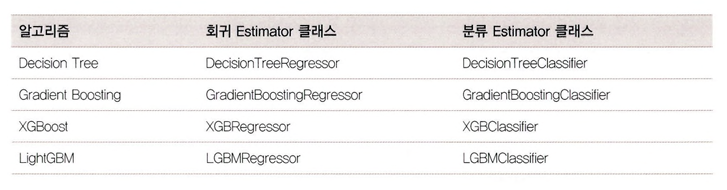

사이킷런의 랜덤 포레스트 회귀 트리인 RandomForestRegressor를 이용해 앞의 선형 회귀에서 다룬 보스턴 주택 가격 예측을 수행해 보겠다.

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the boston dataset from the original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICe 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = target

X_data = pd.DataFrame(data)
y_target = pd.Series(target, name='PRICE')

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores： ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores：  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


이번에는 랜덤 포레스트뿐만 아니라 결정 트리, GBM, XGBoost, LightGBM의 Regressor를 모두 이용해 보스턴 주택 가격 예측을 수행하겠다. 이를 위해 get_model_cv_prediction() 함수를 만든다. get_model_cv_prediction()은 입력 모델과 데이터 세트를 입력받아 교차 검증으로 평균 RMSE를 계산해주는 함수이다.

In [25]:
def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores=cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  rmse_scores=np.sqrt(-1*neg_mse_scores)
  avg_rmse=np.mean(rmse_scores)
  print('#####',model.__class__.__name__,'#####')
  print('5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

이제 다양한 유형의 회귀 트리를 생성하고, 이를 이용해 보스턴 주택 가격을 예측해 보겠다

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

회귀 트리 Regressor 클래스는 선형 회귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없다. 대신 feature_importances_를 이용해 피처별 중요도를 알 수 있다. feature_importances_를 이용해 보스턴 주택 가격 모델의 피처별 중요도를 시각화해 보겠다.

In [22]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

<Axes: xlabel='None', ylabel='None'>

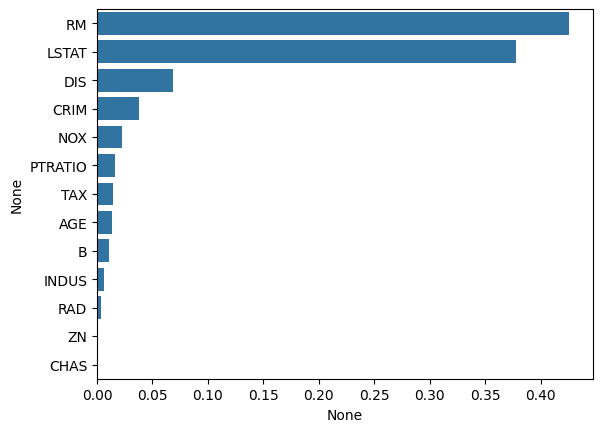

In [23]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X.data, y_target 데이터 세트를 적용해 학습한다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

이번에는 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화해 보겠다. 결정 트리의 하이퍼 파라미터인 max_depth의 크기를 변화시키면서 어떻게 회귀 트리 예측선이 변화하는지 살펴보겠다. 보스턴 주택 데이터 세트를 다시 한번 이용한다. 2차원 평면상에서 회귀 예측선을 쉽게 표현하기 위해서 단 1개의 변수만 추출하겠다. Price와 가장 밀접한 양의 상관관계를 가지는 RM 칼럼만 이용해 선형 회귀와 결정 트리 회귀로 PRICE 예측 회귀선을 표현하겠다.

보스턴 데이터 세트의 개수를 100개만 샘플링하고 RM과 PRICE 칼럼만 추출하겠다. 이는 2차원 평면상에서 X축에 독립변수인 RM, Y축에 종속변수인 PRICE만을 가지고 좀 더 직관적으로 예측값을 시각화하기 위한 것이다. 이 데이터 세트를 산점도 형태로 살펴본다.

(100, 2)


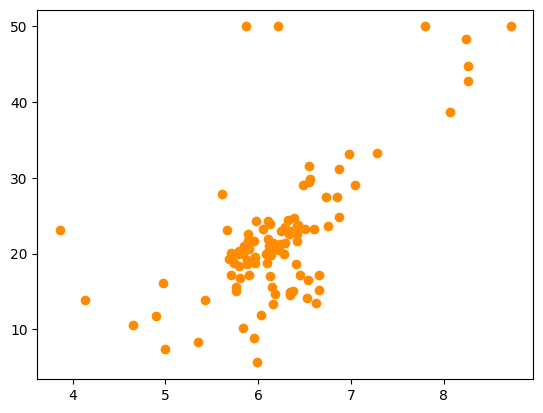

In [27]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt .figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

다음으로 보스턴 데이터 세트에 대해 LinearRegression과 DecisionTreeRegressor를 max_depth를 각각 2, 7로 해서 학습해 보겠다. 이렇게 학습된 Regressor에 RM 값을 4.5~8.5까지의 100개의 테스트 데이터 세트로 제공했을 때 예측값을 구하겠다.

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

LinearRegression과 DecisionTreeRegression의 max_depth를 각각 2,7로 해서 학습된 Regressor에서 예측한 Price 회귀선을 그려보겠다.

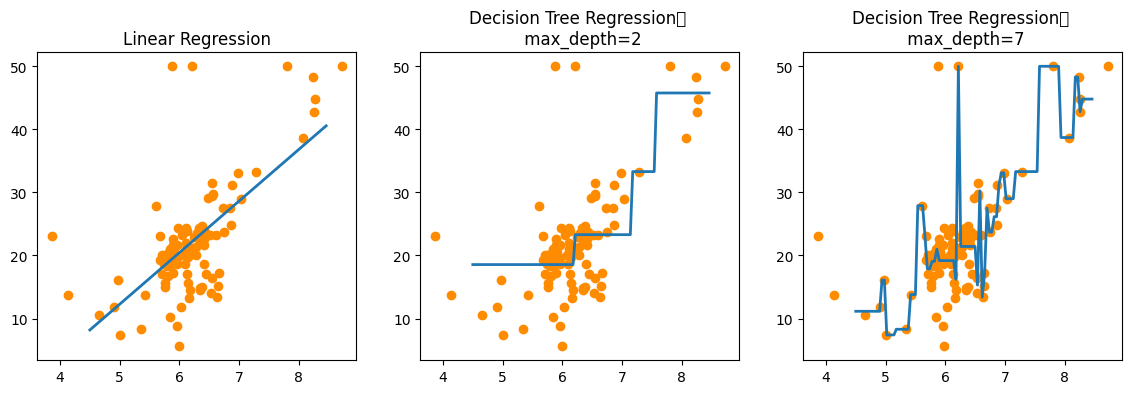

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# X 축 값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression： \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth：3", linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression： \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

선형 회귀는 직선으로 예측 회귀선을 표현하는 데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만든다. DecisionTreeRegressor의 max_depth=7인 경우에는 학습 데이터 세트의 이상치(outlier) 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음을 알 수 있다.